In [1]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt


In [2]:
# Number of points
num_points = 401

# Generate 401 equally spaced points between -1 and 1
points = np.linspace(-1, 1, num_points).astype(np.float32)
input_points = torch.from_numpy(points).type(torch.float32)

# Calculate lower and upper bounds
bounds_offset = 0.01
lower_bounds = points - bounds_offset
upper_bounds = points + bounds_offset

# Create the tensor array of shape (401, 1, 2)
intervals = np.stack((lower_bounds, upper_bounds), axis=-1).reshape(num_points, 1, 2)

# Convert numpy array to torch tensor with dtype=torch.float32
input_tensor = torch.from_numpy(intervals).type(torch.float32)
# Calculate targets using the sine function with dtype=torch.float32
output_tensor = torch.sin(torch.pi * input_points).reshape(len(input_points), 1).type(torch.float32)
print(input_tensor.shape, output_tensor.shape)

torch.Size([401, 1, 2]) torch.Size([401, 1])


In [3]:
def interval_addition(A, B):
    """
    Add two interval matrices.

    Args:
    A: torch tensor, shape (..., 2), interval matrix A
    B: torch tensor, shape (..., 2), interval matrix B

    Returns:
    C: torch tensor, shape (..., 2), interval matrix resulting from A + B
    """
    C_lower = A[..., 0] + B[..., 0]
    C_upper = A[..., 1] + B[..., 1]
    return torch.stack((C_lower, C_upper), dim=-1)


In [4]:
def multiply_interval_matrices(A, B):
    """
    Multiply two interval matrices using interval operations.

    Args:
    A: torch tensor, shape (m, n, 2), interval matrix A
    B: torch tensor, shape (n, p, 2), interval matrix B

    Returns:
    C: torch tensor, shape (m, p, 2), interval matrix resulting from A*B
    """
    # Extract the interval bounds
    A_low, A_high = A[..., 0], A[..., 1]
    B_low, B_high = B[..., 0], B[..., 1]

    # Initialize the result tensor
    m, n, _ = A.shape
    _, p, _ = B.shape
    C = torch.zeros((m, p, 2))

    # Compute all possible products for intervals
    products = torch.stack([
        A_low.unsqueeze(2) * B_low.unsqueeze(0),  # A[i, k, 0] * B[k, j, 0]
        A_low.unsqueeze(2) * B_high.unsqueeze(0), # A[i, k, 0] * B[k, j, 1]
        A_high.unsqueeze(2) * B_low.unsqueeze(0), # A[i, k, 1] * B[k, j, 0]
        A_high.unsqueeze(2) * B_high.unsqueeze(0) # A[i, k, 1] * B[k, j, 1]
    ], dim=-1)

    # Compute min and max across the last dimension
    min_product, _ = torch.min(products, dim=-1)
    max_product, _ = torch.max(products, dim=-1)

    # Sum across the middle dimension (n) for the final result
    C[..., 0] = torch.sum(min_product, dim=1)
    C[..., 1] = torch.sum(max_product, dim=1)

    return C

In [5]:
def relu_interval(x):
    lower, upper = x[..., 0], x[..., 1]
    return torch.stack((nn.Tanh()(lower), nn.Tanh()(upper)), dim=-1)

In [6]:
# Splitting data into training and testing sets
train_input_tensor, test_input_tensor, train_output_tensor, test_output_tensor = train_test_split(
    input_tensor, output_tensor, test_size=0.2, random_state=42
)
print(train_input_tensor.shape, test_input_tensor.shape, train_output_tensor.shape, test_output_tensor.shape)


torch.Size([320, 1, 2]) torch.Size([81, 1, 2]) torch.Size([320, 1]) torch.Size([81, 1])


In [7]:
# Define batch size
batch_size = 64

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(train_input_tensor, train_output_tensor)
test_dataset = TensorDataset(test_input_tensor, test_output_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

torch.manual_seed(2)

In [8]:
class CustomLinear(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomLinear, self).__init__()      
        self.weight = nn.Parameter(torch.Tensor(input_size, output_size, 2))
        self.bias = nn.Parameter(torch.Tensor(1, output_size, 2))
        self.reset_parameters()
        
    def reset_parameters(self):
        # Using Xavier initialization for weights
        nn.init.xavier_normal_(self.weight[..., 0])
        nn.init.xavier_normal_(self.bias[..., 0])
        nn.init.xavier_normal_(self.weight[..., 1])
        nn.init.xavier_normal_(self.bias[..., 1])
        # Ensure the interval property: upper bound >= lower bound
        self.weight.data[..., 1] = self.weight.data[..., 0] + torch.abs(self.weight.data[..., 1])
        # Ensure the interval property for biases
        self.bias.data[..., 1] = self.bias.data[..., 0] + torch.abs(self.bias.data[..., 1])
    
    def forward(self, x):
        weighted_input = multiply_interval_matrices(x, self.weight)
        output = interval_addition(weighted_input, self.bias)
        
        # Ensure interval property is maintained
        lower = torch.min(output[..., 0], output[..., 1])
        upper = torch.max(output[..., 0], output[..., 1])
        
        return torch.stack((lower, upper), dim=-1)
    def project(self):
        # Ensure that the upper bound is greater than or equal to the lower bound
        self.weight.data[..., 1] =   torch.max(self.weight.data[..., 1], self.weight.data[..., 0])
        self.bias.data[..., 1] =   torch.max(self.bias.data[..., 1], self.bias.data[..., 0])
        
# Define the neural network model with custom linear layers
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super(CustomNeuralNetwork, self).__init__()
        self.layer1 = CustomLinear(input_tensor.shape[1], 16)
        self.activation = relu_interval
        #self.activation = relu_interval
        self.layer2 = CustomLinear(16, 16)
        self.activation = relu_interval
        #self.layer3 = CustomLinear(16, 16)
        #self.activation = relu_interval
        self.layer3 = CustomLinear(16, output_tensor.shape[1])

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        #x = self.activation(x)
        x = self.layer2(x)
        x = self.activation(x)
        #x = self.layer3(x)
        #x = self.activation(x)
        x = self.layer3(x)
        return x
    
class IntervalMSELoss(nn.Module):
    def __init__(self, beta):
        super(IntervalMSELoss, self).__init__()
        self.beta = beta

    def distance(self, a, x_lower, x_upper):
        return (1/8) * (2 * a - x_upper - x_lower) ** 2

    def forward(self, y_true, y_pred):
        y_pred_lower = y_pred[..., 0]
        y_pred_upper = y_pred[..., 1]
        y_true = y_true#.squeeze(1)
        
        d = self.distance(y_true, y_pred_lower, y_pred_upper)
        width_term = self.beta * (y_pred_lower - y_pred_upper) ** 2
        loss = torch.mean(d + width_term)
        return loss
    

    
# Initialize the model, loss function, and optimizer
model = CustomNeuralNetwork()
beta = 0.001
criterion = IntervalMSELoss(beta=beta)
optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.5)  # Reduce LR by a factor of 0.5 every 1000 epochs



# Training the model with early stopping, validation loss tracking, and gradient clipping
patience = 500
best_loss = float('inf')
trigger_times = 0
train_losses = []
val_losses = []

# Implement gradient clipping in the training loop
max_grad_norm = 1.0

# Training the model with early stopping and validation loss tracking
epochs = 10000

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for batch_inputs, batch_outputs in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(batch_outputs, outputs)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        epoch_train_loss += loss.item()
        
    scheduler.step()  # Step the learning rate scheduler
    epoch_train_loss /= len(train_loader)

    # Calculate validation loss
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_inputs, batch_outputs in test_loader:
            val_outputs = model(batch_inputs)
            val_loss = criterion(batch_outputs, val_outputs)
            epoch_val_loss += val_loss.item()

    epoch_val_loss /= len(test_loader)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}')

    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
    
    # Project weights and biases to ensure interval constraints
    model.layer1.project()
    model.layer2.project()
    model.layer3.project()

Epoch 100/10000, Loss: 0.015326, Val Loss: 0.021745
Epoch 200/10000, Loss: 0.002481, Val Loss: 0.003377
Epoch 300/10000, Loss: 0.000879, Val Loss: 0.001276
Epoch 400/10000, Loss: 0.000478, Val Loss: 0.000747
Epoch 500/10000, Loss: 0.000412, Val Loss: 0.000657
Epoch 600/10000, Loss: 0.000381, Val Loss: 0.000613
Epoch 700/10000, Loss: 0.000364, Val Loss: 0.000570
Epoch 800/10000, Loss: 0.000373, Val Loss: 0.000553
Epoch 900/10000, Loss: 0.000345, Val Loss: 0.000468
Epoch 1000/10000, Loss: 0.000230, Val Loss: 0.000341
Epoch 1100/10000, Loss: 0.000152, Val Loss: 0.000251
Epoch 1200/10000, Loss: 0.000103, Val Loss: 0.000166
Epoch 1300/10000, Loss: 0.000063, Val Loss: 0.000094
Epoch 1400/10000, Loss: 0.000042, Val Loss: 0.000046
Epoch 1500/10000, Loss: 0.000025, Val Loss: 0.000024
Epoch 1600/10000, Loss: 0.000039, Val Loss: 0.000043
Epoch 1700/10000, Loss: 0.000068, Val Loss: 0.000033
Epoch 1800/10000, Loss: 0.000054, Val Loss: 0.000027
Epoch 1900/10000, Loss: 0.000035, Val Loss: 0.000026
Ep

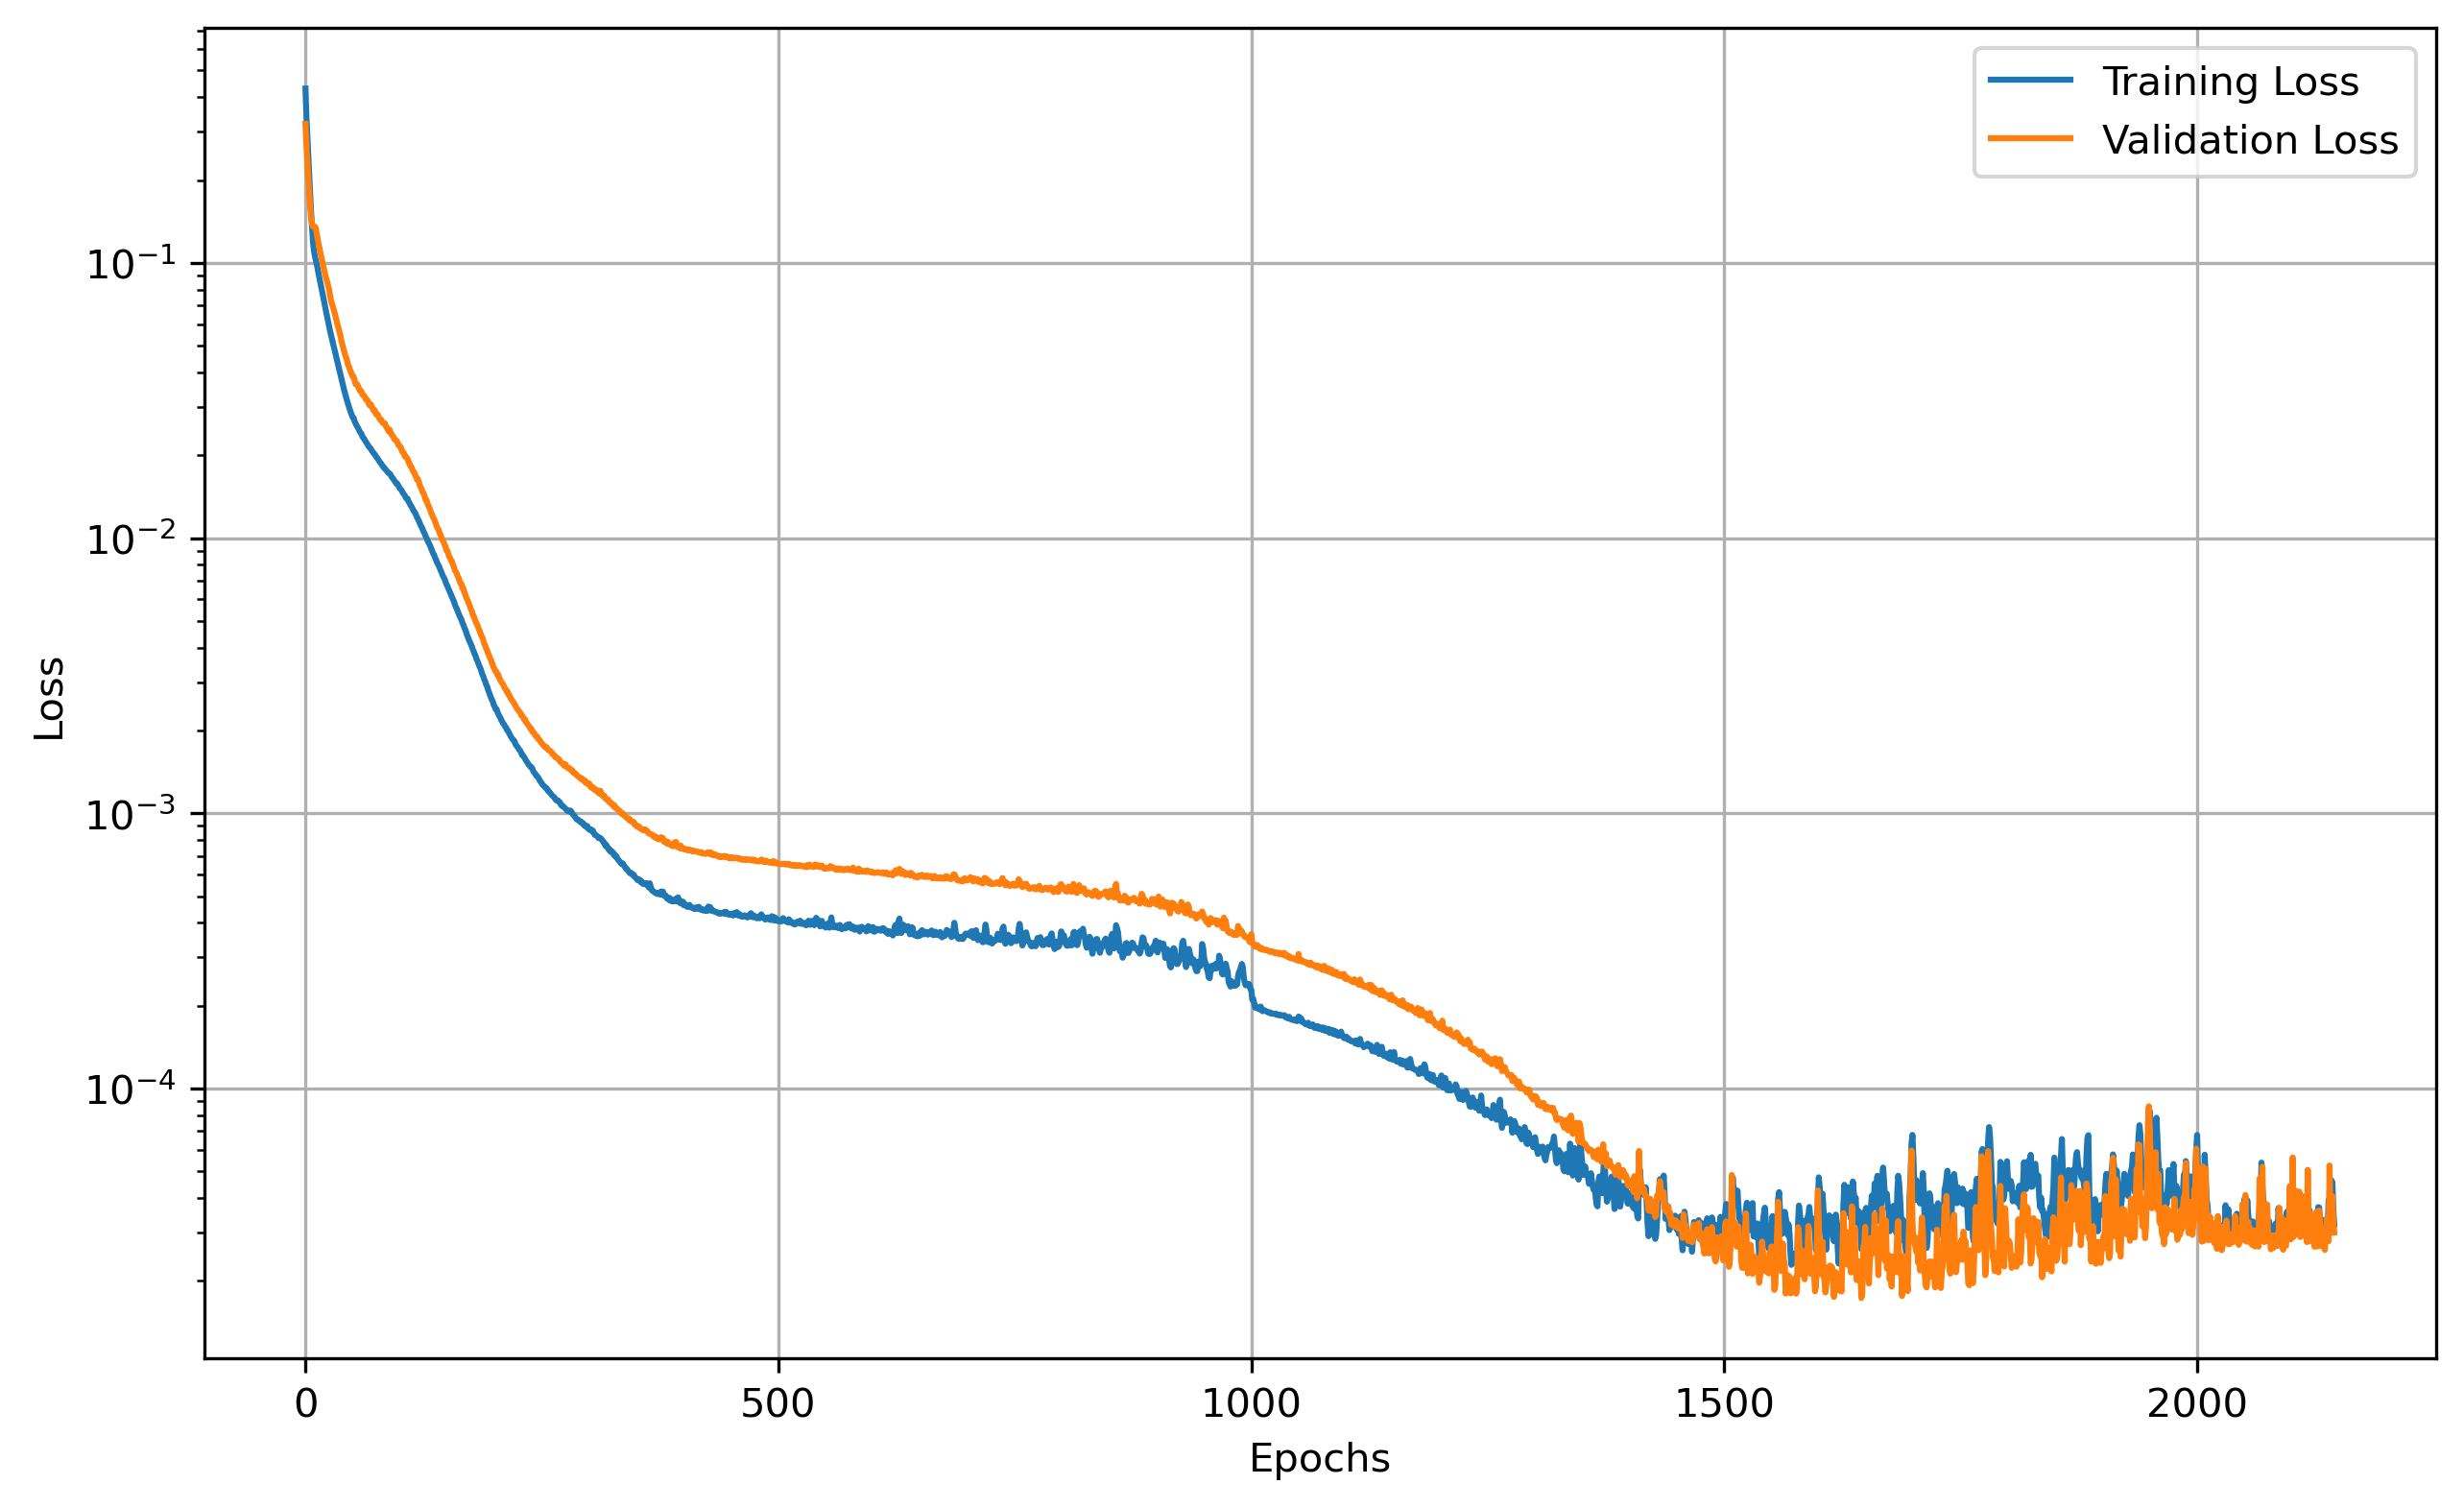

In [9]:
# Plotting training and validation loss curves
plt.figure(figsize=(10, 6), dpi = 300)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
#plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
#plt.show()
plt.savefig('Training and Validation Loss Curve.pdf')

In [10]:
# Evaluate the trained model
with torch.no_grad():
    outputs = model(input_tensor)
    accuracy = (1 - torch.abs((outputs[..., 0] + outputs[..., 1])/2 - output_tensor).mean()).float()
    print(f'Accuracy: {accuracy.item():.6f}')

Accuracy: 0.994409


In [11]:
outputs = model(input_tensor)

In [12]:
print(output_tensor.shape)

torch.Size([401, 1])


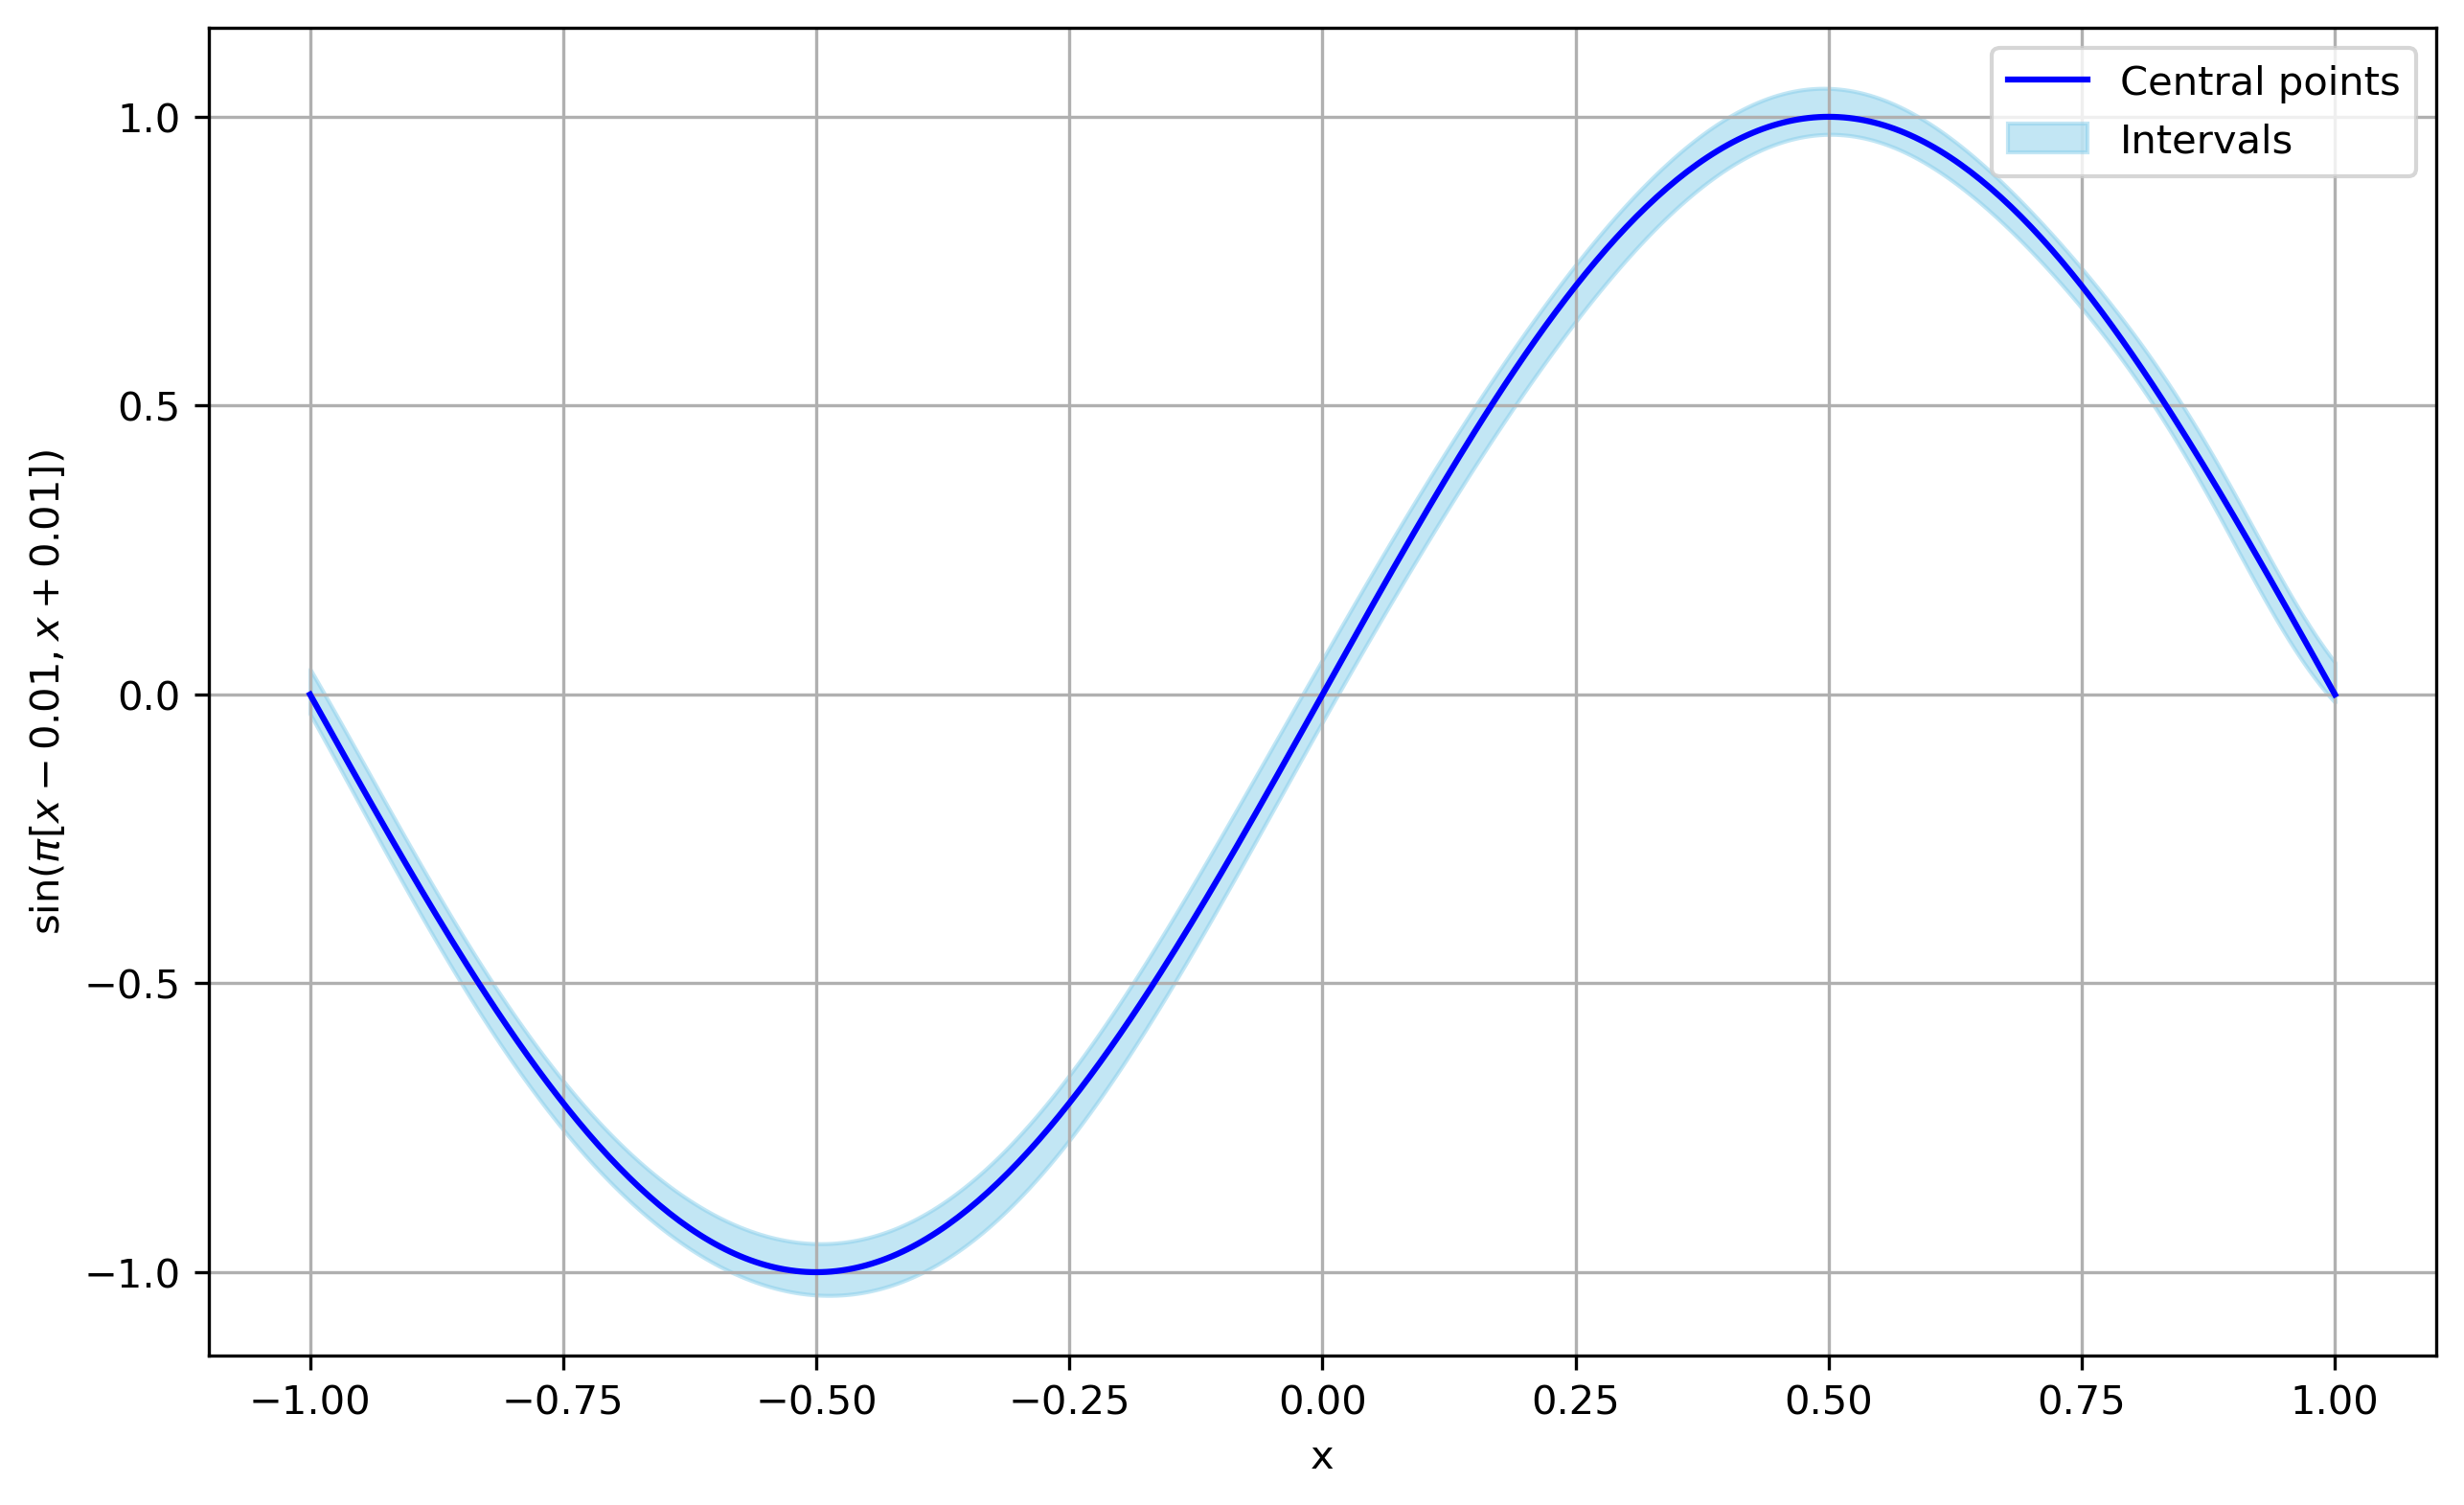

In [13]:
# Number of points
num_points = 401

# Generate 401 equally spaced points between -1 and 1
points = np.linspace(-1, 1, num_points)

# Compute sine of the intervals
sin_lower_bounds = outputs[...,0].detach().numpy().flatten()
sin_upper_bounds = outputs[...,1].detach().numpy().flatten()

# Plot the interval-valued function for sine
plt.figure(figsize=(10, 6), dpi = 300)
plt.plot(points, np.sin(np.pi * points), label='Central points', color='blue')
plt.fill_between(points, sin_lower_bounds, sin_upper_bounds, color='skyblue', alpha=0.5, label='Intervals')

# Adding labels and title
plt.xlabel('x')
plt.ylabel(r'$\sin(\pi [x-0.01,x+0.01])$') #'sin(pi * interval values)'
#plt.title('sin()')
plt.grid(True)
plt.legend()

# Display the plot
#plt.show()
plt.savefig('sin(Interval Valued function).pdf')

In [14]:
# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)

Total number of trainable parameters: 642
